<h1 align="center">Time Series</h1>

<html>
<h1  align="center"> 
    <hr>
    <img align="center;" style="background-color:
#253bff"; color:"#ff5d25";" src="https://polzinben.github.io/images/time_series.jpg"; width="30%"; height="20%">

</h1>
</html>

<h1 align="center">Índice del análisis</h1>

- [**Introduccion**](#Introduccion)
- [**Librerias**](#Librerias)
- [**Datos**](#Datos)
- [**Limpieza**](#Limpieza)
- [**TimeSeries**](#TimeSeries)

<html><h1 align="center", style="background: #e84179; color:white">Introduccion</h1></html>

[**Volver al Inicio**](#Índice-del-análisis) 

#### ¿Qué es una serie de tiempo?

Podemos definir una **serie de tiempo** como un conjunto de observaciones tomadas en **intervalos regulares** que se encuentran **ordenadas** por el momento en que se produjeron.

El análisis de series de tiempo se suele utilizar para proyectar o pronosticar la evolución de una variable a lo largo del tiempo, a partir de información previa sobre esa misma variable. Es decir, tenemos que proyectar una variable determinada (eje y) en función del tiempo (eje x). 


#### Descomposición de una serie de tiempo


Existen distintos tipos de modelos para tratar las series de tiempo. 
Una opción es modelar una serie de tiempo como compuesta por **cuatro componentes**:
- **Tendencia**: componente “permanente”, el efecto persiste en el largo plazo. Se puede interpretar como lo que motiva el cambio a largo plazo de la media.
- **Estacionalidad**: esta componente aporta movimientos periódicos a la serie.
- **Ciclos**: se entiende por cualquier tipo de dinámica no capturada por la tendencia o la estacionalidad. Estamos ante la presencia de ciclos cuando observamos algún tipo de dinámica mediante la cual el presente está vinculado al pasado. No tiene por qué ser un ciclo rígido.
- **Componente aleatoria**: son shocks que no presentan un efecto duradero, ya que las suponemos i.i.d. con media 0 y varianza constante.

De manera aditiva, podemos decir entonces que: 

$$ y_t = T_t + S_t + C_t + \varepsilon_t. $$

… donde T es la tendencia, S es el efecto estacional C es el ciclo y $ \varepsilon $ es el error aleatorio.

<html><h1 align="center", style="background: #e84179; color:white">Librerias</h1></html>

[**Volver al Inicio**](#Índice-del-análisis) 

In [56]:
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import matplotlib.patches
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from math import sqrt
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import pmdarima as pm
from os import listdir
import warnings

warnings.filterwarnings('ignore')

<html><h1 align="center", style="background: #e84179; color:white">Datos</h1></html>

[**Volver al Inicio**](#Índice-del-análisis) 

In [57]:
dfs = pd.read_csv('df.csv').drop(columns = 'Unnamed: 0')

In [58]:
dfs.head(5)

,tramite_fecha,registro_seccional_provincia,count
0,2018-09-14,Córdoba,858
1,2018-09-28,Entre Ríos,268
2,2018-09-07,Mendoza,423
3,2018-09-04,Río Negro,152
4,2018-09-20,Catamarca,43


In [59]:
df = dfs.pivot_table(index='tramite_fecha',
               columns='registro_seccional_provincia',
               values='count',
               fill_value=0)

df.columns.name = None              

df = df.loc[:,~df.apply(lambda x: x.duplicated(),axis=1).all()].copy()

In [60]:
df["sum"] = df[df.columns[1:]].sum(axis=1)

In [61]:
from pandas.tseries.offsets import BDay
isBusinessDay = BDay().onOffset

df['tramite_fecha'] = df.index
df["tramite_fecha"] = pd.to_datetime(df["tramite_fecha"])

match_series = pd.to_datetime(df['tramite_fecha']).map(isBusinessDay)
df = df[(df['sum'] >= 100)]
df = df[match_series]

df_copy = df.copy()

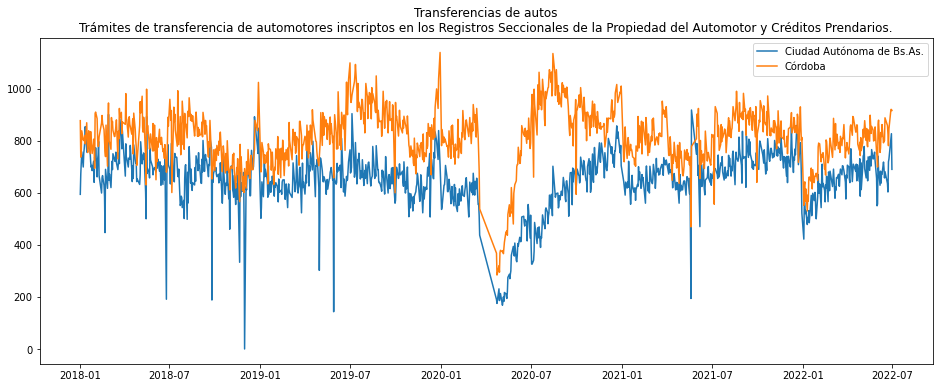

In [62]:
def get_time_series(df, values):
    plt.rcParams["figure.figsize"] = (16,6)
    fig, ax1 = plt.subplots()
    for value in values:
        ax1.plot(pd.to_datetime(df.index), df[value], label=value);
    ax1.legend(values)
    plt.title('Transferencias de autos\nTrámites de transferencia de automotores inscriptos en los Registros Seccionales de la Propiedad del Automotor y Créditos Prendarios.')
    return plt.show()

get_time_series(df_copy, ['Ciudad Autónoma de Bs.As.', 'Córdoba'])

In [63]:
df['año']     = pd.DatetimeIndex(df['tramite_fecha']).year
df['mes_año'] = pd.to_datetime(df['tramite_fecha']).dt.to_period('M')

In [64]:
def get_line_plot(dataframe, x, y1, y2, titulo, rolling = False, periods = False):
    df = dataframe.copy()
    if rolling == True:
        df[y1] = df[y1].rolling(window=periods).mean()
        df[y2] = df[y2].rolling(window=periods).mean()
    subfig = make_subplots(specs=[[{"secondary_y": True}]])
    fig  = px.line(df, x=x, y=y1)
    fig2 = px.line(df, x=x,y=y2)
    fig.update_layout(xaxis_rangeslider_visible=True)
    fig.update_traces(showlegend=True,name=y1,line_color='red', line_width=1)
    fig2.update_traces(showlegend=True,name=y2,line_color='#0000ff', line_width=1, yaxis="y2")
    subfig.add_traces(fig.data + fig2.data)
    subfig.layout.xaxis.title ="Periodos"
    subfig.layout.yaxis.title =y1
    subfig.layout.yaxis2.title=y2
    subfig.layout.title=titulo 
    return subfig.show()

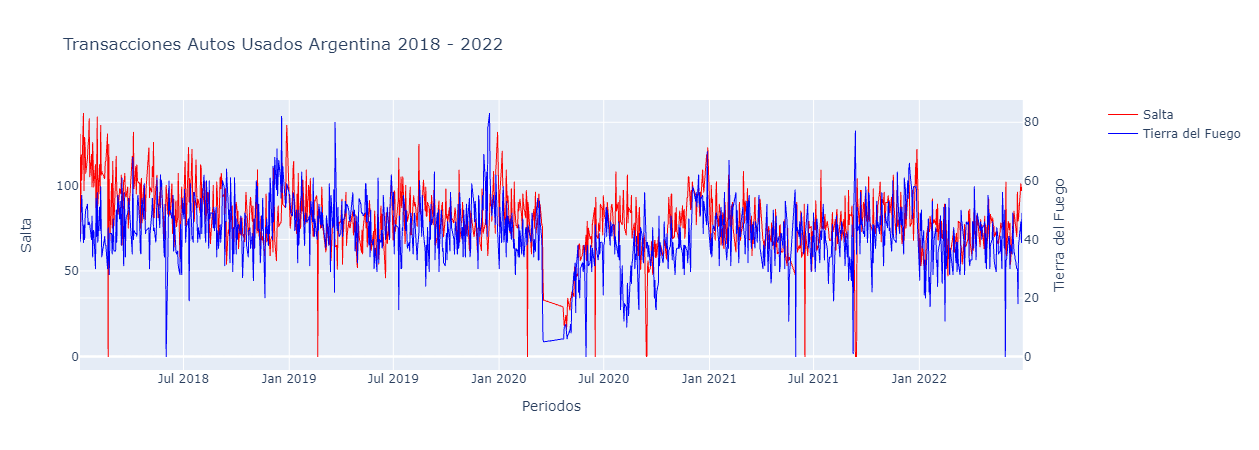

In [65]:
get_line_plot(df_copy, "tramite_fecha", "Salta", "Tierra del Fuego", "Transacciones Autos Usados Argentina 2018 - 2022")

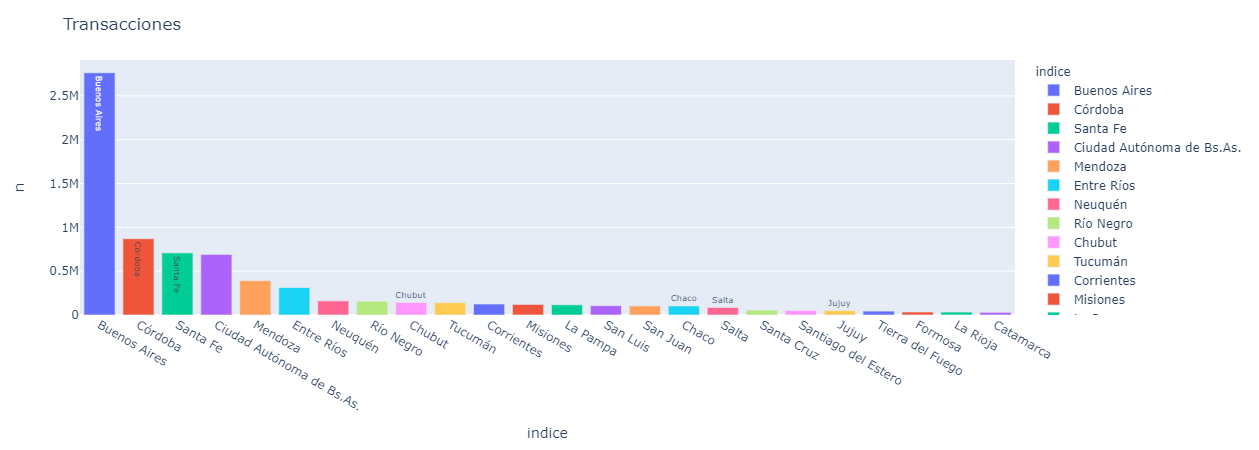

In [66]:
def plot_hbar(df, x, y, title):
    fig = px.bar(df, 
                 x=x, y=y, 
                 text=x, orientation='v', width=700, color = x)
    fig.update_layout(title=title, xaxis_title=x, yaxis_title=y,
                      uniformtext_minsize=8, uniformtext_mode='hide')
    fig.show()


columnas = []
values   = []

for i in range(len(df_copy.drop(columns = ['sum','tramite_fecha']).columns)):
    try:
        columnas.append(df_copy.drop(columns =['sum','tramite_fecha']).columns[i])
        values.append(df_copy[df_copy.drop(columns = ['sum','tramite_fecha']).columns[i]].sum())
    except:
        continue

df_group = pd.DataFrame({'indice': columnas, 'n' : values}).sort_values(by = 'n', ascending = False)
plot_hbar(df_group, 'indice', 'n',  'Transacciones')

In [67]:
df_mes = df.groupby('mes_año')[df.columns.drop(["tramite_fecha", 'año', 'mes_año'])].mean().reset_index()
df_mes["mes_año"] = [d.to_timestamp() for d in df_mes["mes_año"].values]

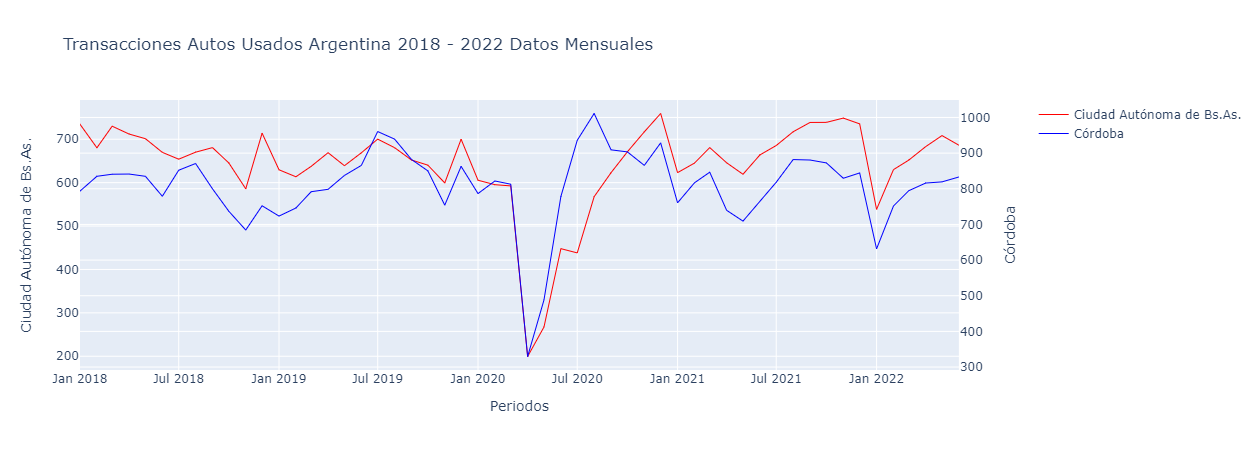

In [68]:
get_line_plot(df_mes, "mes_año", "Ciudad Autónoma de Bs.As.", "Córdoba", "Transacciones Autos Usados Argentina 2018 - 2022 Datos Mensuales")

In [69]:
df_mes["mes_año"] = pd.to_datetime(df_mes["mes_año"])
df_mes['año'] = pd.to_datetime(df_mes["mes_año"]).dt.year
#df_mes.to_csv(r'cars.csv')

<html><h1 align="center", style="background: #e84179; color:white">Limpieza</h1></html>

[**Volver al Inicio**](#Índice-del-análisis) 

Desde el 18 de marzo al 19 de junio no contamos con datos. Si bien no es buena practica en series de tiempo alterar los datos en este caso, la pandemia ha alterado todas las series temporales. Para este caso se va a tener en cuenta los promedios de los otros años para esas fechas asi podemos completar al serie temporal.

In [70]:
def get_dataframe(values, desde, hasta, years):
    data_frames = []
    for year in years:
        df_append = df_copy.loc[(df_copy['tramite_fecha'].dt.strftime('%m-%d') >= desde) & (df_copy['tramite_fecha'].dt.strftime('%m-%d') <= hasta) & (df_copy['tramite_fecha'].dt.strftime('%Y') == year)][values]
        data_frames.append(df_append)
    df_final_concat = pd.concat(data_frames, ignore_index=True)
    df_final_concat['month_day'] = df_final_concat['tramite_fecha'].dt.strftime('%m-%d')
    df_values = df_final_concat.groupby('month_day' ,as_index = False).mean().round(0)
    return df_values

start    = '03-18'
end      = '06-19'
columnas = ['tramite_fecha', 'Buenos Aires', 'Catamarca', 'Chaco', 'Chubut','Ciudad Autónoma de Bs.As.', 'Corrientes', 'Córdoba', 'Entre Ríos',
        'Formosa', 'Jujuy', 'La Pampa', 'La Rioja', 'Mendoza', 'Misiones',
        'Neuquén', 'Río Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz', 'Santa Fe', 'Santiago del Estero', 'Tierra del Fuego', 'Tucumán', 'sum']

df_values = get_dataframe(columnas, start, end, ['2018', '2019', '2021', '2022'])

In [71]:
df_values['month_day'] = df_values.apply(lambda x: '2020-' + str(x['month_day']), axis = 1)

df_values['month_day'] = pd.to_datetime(df_values['month_day'], format='%Y-%m-%d')

df_values.head(5)

,month_day,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,...,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum
0,2020-03-18,2622.0,28.0,80.0,123.0,654.0,106.0,817.0,282.0,30.0,...,150.0,70.0,93.0,74.0,56.0,619.0,48.0,43.0,119.0,4152.0
1,2020-03-19,2629.0,29.0,108.0,149.0,666.0,108.0,770.0,252.0,29.0,...,138.0,82.0,89.0,103.0,62.0,603.0,59.0,41.0,120.0,4183.0
2,2020-03-20,2530.0,38.0,114.0,132.0,670.0,124.0,771.0,291.0,30.0,...,163.0,94.0,90.0,92.0,63.0,646.0,40.0,56.0,110.0,4374.0
3,2020-03-21,2588.0,27.0,96.0,121.0,704.0,109.0,821.0,297.0,42.0,...,160.0,86.0,91.0,101.0,61.0,638.0,48.0,36.0,122.0,4371.0
4,2020-03-22,2768.0,30.0,99.0,146.0,706.0,110.0,856.0,292.0,38.0,...,154.0,82.0,92.0,100.0,64.0,656.0,51.0,45.0,128.0,4467.0


In [72]:
df_values.rename(columns = {'month_day':'tramite_fecha'}, inplace = True)

In [73]:
df_values.index = df_values.tramite_fecha

df_values.head(3)

,tramite_fecha,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,...,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum
tramite_fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-18,2020-03-18,2622.0,28.0,80.0,123.0,654.0,106.0,817.0,282.0,30.0,...,150.0,70.0,93.0,74.0,56.0,619.0,48.0,43.0,119.0,4152.0
2020-03-19,2020-03-19,2629.0,29.0,108.0,149.0,666.0,108.0,770.0,252.0,29.0,...,138.0,82.0,89.0,103.0,62.0,603.0,59.0,41.0,120.0,4183.0
2020-03-20,2020-03-20,2530.0,38.0,114.0,132.0,670.0,124.0,771.0,291.0,30.0,...,163.0,94.0,90.0,92.0,63.0,646.0,40.0,56.0,110.0,4374.0


In [74]:
df_ts_1 = df_copy[columnas]

df_ts_1.head(3)

,tramite_fecha,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,...,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum
tramite_fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2018-01-02,2719,43,94,145,594,178,877,271,44,...,182,130,89,106,70,724,74,39,157,4666
2018-01-03,2018-01-03,2809,45,141,134,672,184,737,285,42,...,182,69,95,112,49,623,51,41,167,4577
2018-01-04,2018-01-04,2857,30,121,139,714,157,760,286,43,...,169,118,108,110,81,689,68,50,182,4773


In [75]:
df_ts_1.index =  pd.to_datetime(df_ts_1.index, format='%Y-%m-%d')

In [76]:
df_ts_1['tramite_fecha']   = df_ts_1.index
df_values['tramite_fecha'] = df_values.index

In [77]:
delete_index = list(df_values.index.unique())

In [78]:
df_ts = pd.concat([df_ts_1[~df_ts_1.index.isin(delete_index)], df_values], ignore_index = False)

In [79]:
df_ts.head(3)

,tramite_fecha,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,...,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum
tramite_fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2018-01-02,2719.0,43.0,94.0,145.0,594.0,178.0,877.0,271.0,44.0,...,182.0,130.0,89.0,106.0,70.0,724.0,74.0,39.0,157.0,4666.0
2018-01-03,2018-01-03,2809.0,45.0,141.0,134.0,672.0,184.0,737.0,285.0,42.0,...,182.0,69.0,95.0,112.0,49.0,623.0,51.0,41.0,167.0,4577.0
2018-01-04,2018-01-04,2857.0,30.0,121.0,139.0,714.0,157.0,760.0,286.0,43.0,...,169.0,118.0,108.0,110.0,81.0,689.0,68.0,50.0,182.0,4773.0


In [80]:
df_ts.index.name = 'index'
df_ts.sort_values(by = 'tramite_fecha', inplace = True)

In [81]:
df_ts.head(5)

,tramite_fecha,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,...,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum
index,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2018-01-02,2719.0,43.0,94.0,145.0,594.0,178.0,877.0,271.0,44.0,...,182.0,130.0,89.0,106.0,70.0,724.0,74.0,39.0,157.0,4666.0
2018-01-03,2018-01-03,2809.0,45.0,141.0,134.0,672.0,184.0,737.0,285.0,42.0,...,182.0,69.0,95.0,112.0,49.0,623.0,51.0,41.0,167.0,4577.0
2018-01-04,2018-01-04,2857.0,30.0,121.0,139.0,714.0,157.0,760.0,286.0,43.0,...,169.0,118.0,108.0,110.0,81.0,689.0,68.0,50.0,182.0,4773.0
2018-01-05,2018-01-05,2884.0,46.0,122.0,162.0,757.0,179.0,838.0,300.0,56.0,...,171.0,103.0,121.0,116.0,72.0,643.0,71.0,55.0,149.0,4912.0
2018-01-08,2018-01-08,2711.0,35.0,130.0,165.0,699.0,162.0,803.0,293.0,47.0,...,188.0,142.0,96.0,71.0,62.0,641.0,85.0,39.0,137.0,4682.0


Ahora podemos ver la serie completa con los datos promedio de los años anteriores y posteriores al periodo del 2020 donde no teniamos datos.

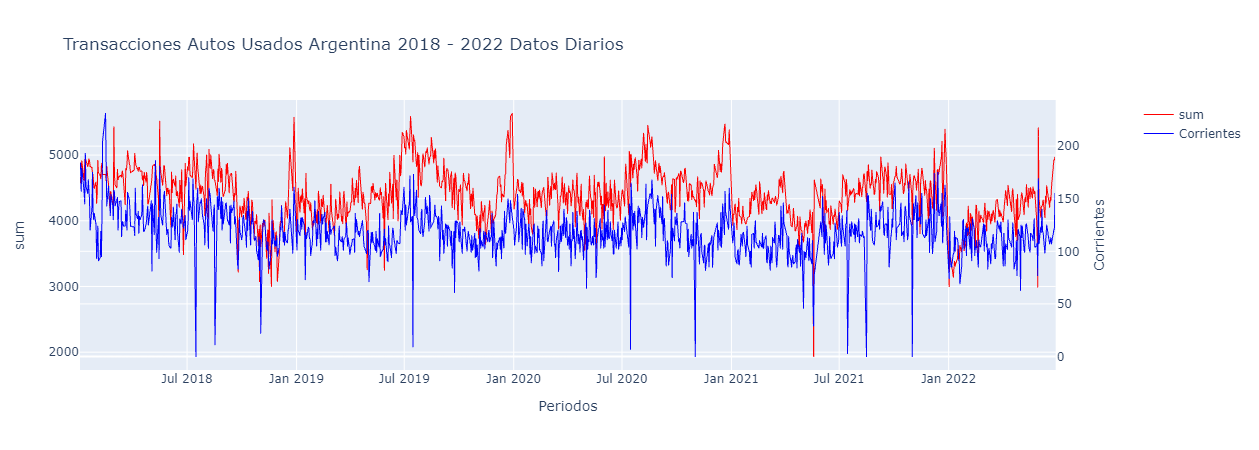

In [82]:
get_line_plot(df_ts, "tramite_fecha", "sum", "Corrientes", "Transacciones Autos Usados Argentina 2018 - 2022 Datos Diarios")

Grafico Mensual

In [83]:
df_ts['mes_año'] = pd.to_datetime(df_ts['tramite_fecha']).dt.to_period('M')
df_mes = df_ts.groupby('mes_año')[df_ts.columns.drop(["tramite_fecha"])].mean().round(0).reset_index()
df_mes["mes_año"] = [d.to_timestamp() for d in df_mes["mes_año"].values]

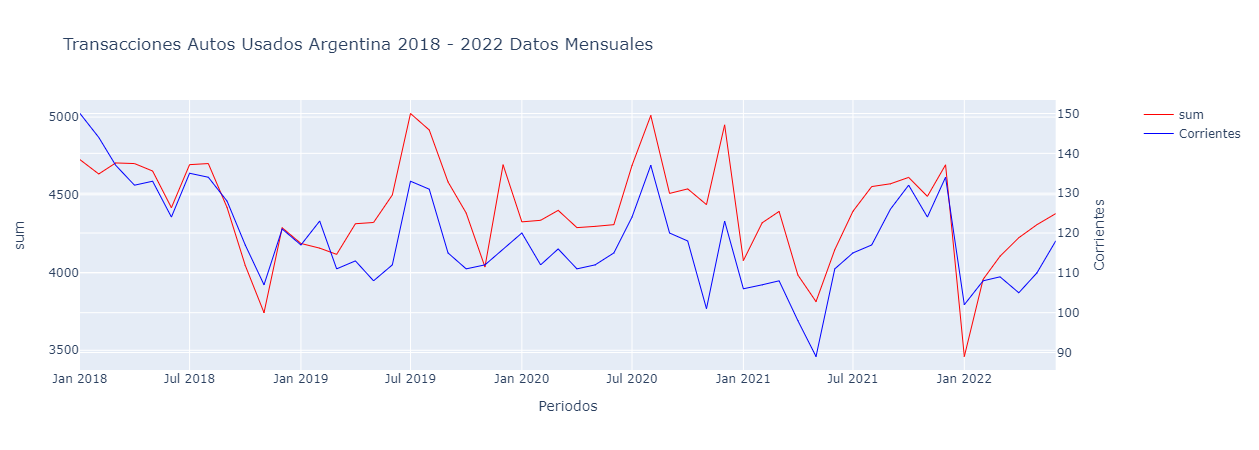

In [84]:

get_line_plot(df_mes, "mes_año", "sum", "Corrientes", "Transacciones Autos Usados Argentina 2018 - 2022 Datos Mensuales")

In [85]:
df_ts.head(5)

,tramite_fecha,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,...,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum,mes_año
index,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2018-01-02,2719.0,43.0,94.0,145.0,594.0,178.0,877.0,271.0,44.0,...,130.0,89.0,106.0,70.0,724.0,74.0,39.0,157.0,4666.0,2018-01
2018-01-03,2018-01-03,2809.0,45.0,141.0,134.0,672.0,184.0,737.0,285.0,42.0,...,69.0,95.0,112.0,49.0,623.0,51.0,41.0,167.0,4577.0,2018-01
2018-01-04,2018-01-04,2857.0,30.0,121.0,139.0,714.0,157.0,760.0,286.0,43.0,...,118.0,108.0,110.0,81.0,689.0,68.0,50.0,182.0,4773.0,2018-01
2018-01-05,2018-01-05,2884.0,46.0,122.0,162.0,757.0,179.0,838.0,300.0,56.0,...,103.0,121.0,116.0,72.0,643.0,71.0,55.0,149.0,4912.0,2018-01
2018-01-08,2018-01-08,2711.0,35.0,130.0,165.0,699.0,162.0,803.0,293.0,47.0,...,142.0,96.0,71.0,62.0,641.0,85.0,39.0,137.0,4682.0,2018-01


In [86]:
df_ts.head(5)

,tramite_fecha,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad Autónoma de Bs.As.,Corrientes,Córdoba,Entre Ríos,Formosa,...,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán,sum,mes_año
index,,,,,,,,,,,,,,,,,,,,,
2018-01-02,2018-01-02,2719.0,43.0,94.0,145.0,594.0,178.0,877.0,271.0,44.0,...,130.0,89.0,106.0,70.0,724.0,74.0,39.0,157.0,4666.0,2018-01
2018-01-03,2018-01-03,2809.0,45.0,141.0,134.0,672.0,184.0,737.0,285.0,42.0,...,69.0,95.0,112.0,49.0,623.0,51.0,41.0,167.0,4577.0,2018-01
2018-01-04,2018-01-04,2857.0,30.0,121.0,139.0,714.0,157.0,760.0,286.0,43.0,...,118.0,108.0,110.0,81.0,689.0,68.0,50.0,182.0,4773.0,2018-01
2018-01-05,2018-01-05,2884.0,46.0,122.0,162.0,757.0,179.0,838.0,300.0,56.0,...,103.0,121.0,116.0,72.0,643.0,71.0,55.0,149.0,4912.0,2018-01
2018-01-08,2018-01-08,2711.0,35.0,130.0,165.0,699.0,162.0,803.0,293.0,47.0,...,142.0,96.0,71.0,62.0,641.0,85.0,39.0,137.0,4682.0,2018-01


<html><h1 align="center", style="background: #e84179; color:white">TimeSeries</h1></html>

[**Volver al Inicio**](#Índice-del-análisis) 

Primero vamos a aprovechar los datos que tenemos para las series diarias, es decir, el mes y el dia de la semana de cada observacion. Con estos datos podemos generar un modelo
para predecir valores en base a las nuevas features.

Podemos descomponer la serie para ver sus componentes de tendencia, estacionalidad y componente aleatorio utilizando una libreria de statsmodels.

La Aditiva me va a servir cuando la variacion estacional es constante en el tiempo y la multiplicativa si existe tendencia lineal o exponencial. Para este caso utilizaremos aditiva.

Vemos que no hay tendencia pero parece haber un componente estacional en algunos periodos.

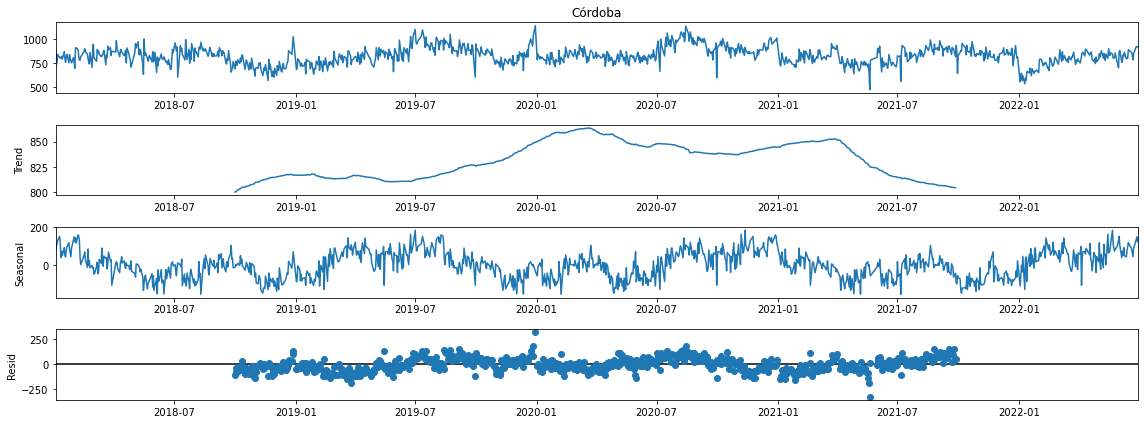

In [87]:
s_dec_additive = seasonal_decompose(df_ts['Córdoba'], model = 'additive', period = 365)
s_dec_additive.plot()
plt.show()

Se hace una copia del data frame para solo analizar los datos de Cordoba

In [88]:
df_p = df_ts[['Córdoba']].copy()

In [89]:
df_p.head(3)

,Córdoba
index,
2018-01-02,877.0
2018-01-03,737.0
2018-01-04,760.0


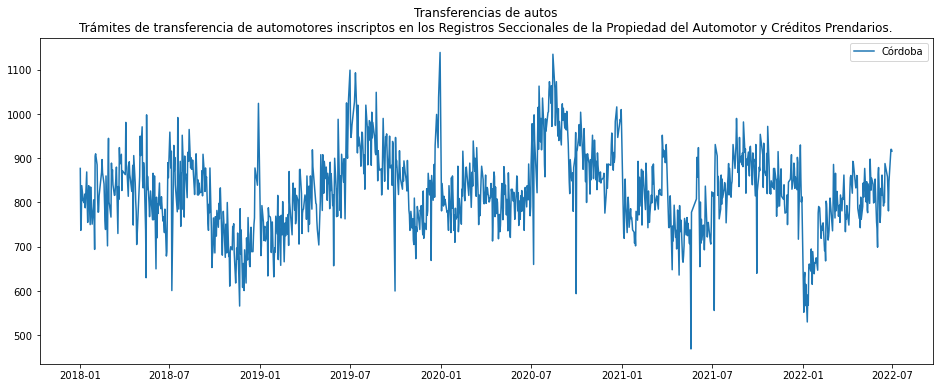

In [90]:
get_time_series(df_p, ['Córdoba'])

Tambien podemos separar las series de tiempo por año y asi poder visualizar si hay comportamientos similares:

In [91]:
df_mes.index = df_mes['mes_año']
df_s = df_mes.copy()
df_s = df_s[['Córdoba']]
df_s['Córdoba'] = np.log(df_s.Córdoba.values)
df_s['year']    = [d.year for d in df_s.index]
df_s['month']   = [d.strftime('%b') for d in df_s.index]
years = df_s['year'].unique()

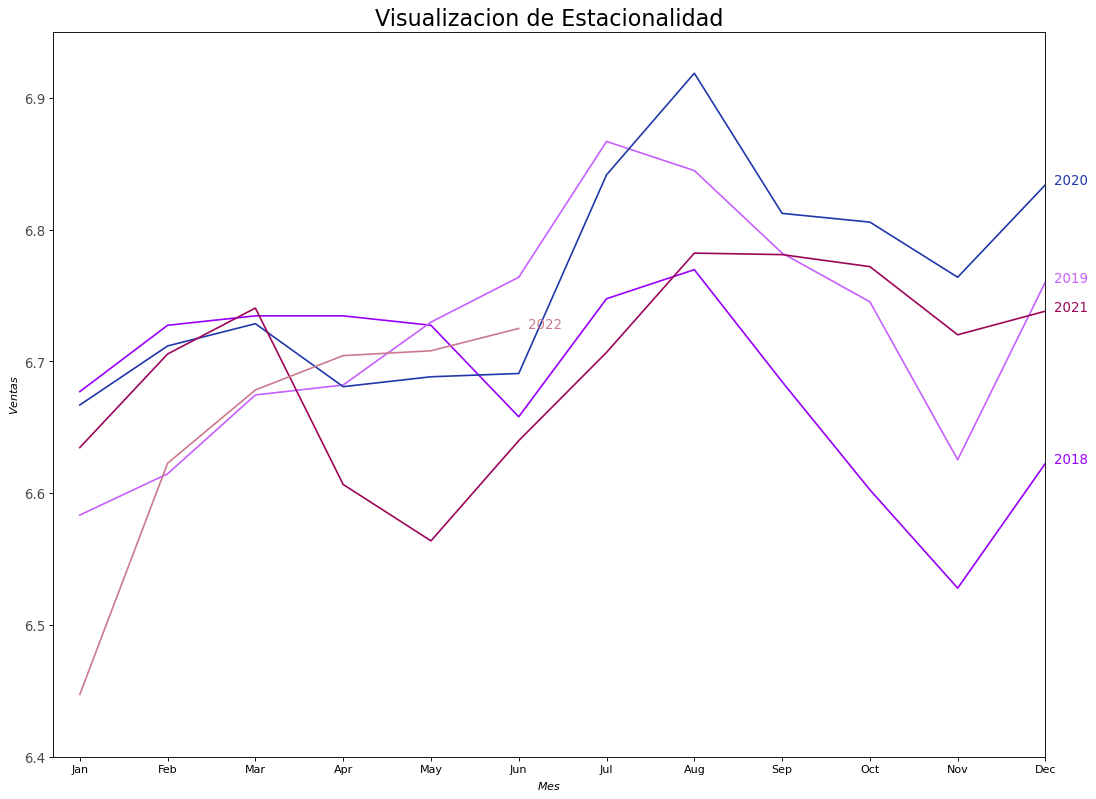

In [92]:
# Preparamos los colores:
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Ploteamos
plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    plt.plot('month', 'Córdoba', data=df_s.loc[df_s.year==y, :], color=mycolors[i], label=y)
    plt.text(df_s.loc[df_s.year==y, :].shape[0] -.9, df_s.loc[df_s.year==y, 'Córdoba'][-1:].values[0], y, fontsize=12, color=mycolors[i])


plt.gca().set(xlim=(-0.3, 11), ylim=(6.4, 6.95), ylabel='$Ventas$', xlabel='$Mes$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Visualizacion de Estacionalidad", fontsize=20);

Dividimos el data set en training y test, seteamos shuffle false para que los datos de train sean los ultimos

In [93]:
train, test = train_test_split(df_p, test_size = 50, random_state = 10, shuffle = False)

In [94]:
train.tail(2)

,Córdoba
index,
2022-04-11,821.0
2022-04-12,893.0


In [95]:
test.head(2)

,Córdoba
index,
2022-04-13,890.0
2022-04-18,833.0


El primer modelo que se va a usar es el random walk donde la variable presente depende de la variable en el periodo anterior

In [55]:
'''hasta min 52 video'''

'hasta min 52 video'

Prueba de Dickey Fuller para verificar si un conjunto de datos proviene de un proceso estacionario o no. La prueba esta basada en un contraste de hipotesis.

Hipotesis Nula: La serie no es estacionaria

Hipotesis Alternativa: La serie es estacionaria


In [ ]:
def get_adfuller(value):
    if sts.adfuller(value)[0] > sts.adfuller(value)[4]['1%']:
        print('No rechazamos hipotesis nula, la serie NO ES estacionaria a un nivel de significacion del 1 % con un numero de retrasos de: ', sts.adfuller(value)[2])
    elif sts.adfuller(value)[0] > sts.adfuller(value)[4]['5%']:
        print('No rechazamos hipotesis nula, la serie NO ES estacionaria a un nivel de significacion del 5 % con un numero de retrasos de: ', sts.adfuller(value)[2])
    elif sts.adfuller(value)[0] > sts.adfuller(value)[4]['10%']:
        print('No rechazamos hipotesis nula, la serie NO ES estacionaria a un nivel de significacion del 10 % con un numero de retrasos de: ', sts.adfuller(value)[2])

    else: print('La serie ES estacionaria')
    return sts.adfuller(value)

get_adfuller(df_ts["Córdoba"])

Estacionalidad:

Sugiere que ciertas tendencias aparecerán de forma cíclica, por ejemplo, las temperaturas suben y bajan a lo largo del tiempo. La series se pueden descomponer bajo efecto tendencia donde podemos quitar un patrón sostenido en los datos, la estacional los efectos cíclicos y el residual el error entre los datos reales y el modelo que estamos ejecutando.

La descomposición clásica puede ser aditiva o multiplicativa, en la aditiva podemos suponer que en cualquier momento del tiempo el valor observado es la suma de la tendencia, el objeto estacional y el efecto residual para ese periodo.

La descomposición multiplicativa nos dice que la serie original es un producto de los tres efectos anteriories.

In [ ]:
df_ts.sort_index(inplace=True)

In [ ]:
df_ts.dropna(axis = 0, inplace=True)

In [ ]:
df_ts.index

In [ ]:
df_ts.head(3)

In [ ]:
s_dec_additive = seasonal_decompose(df_ts['Córdoba'], model = 'additive', freq = 365)
s_dec_additive.plot()
plt.show()

In [ ]:
s_dec_additive = seasonal_decompose(df_ts['Córdoba'],model = 'multiplicative', freq = 365)
s_dec_additive.plot()
plt.show()

ACF autocorrelacion

Los lags son los retrasos, por buenas practicas se usa 40, el zero false nos dice que si vamos a incluir el valor del periodo actual, le pusimos false porque  no es necesario incluirlo  ya que la correlacion  entre un valor y si mismo siempre sera 1

In [ ]:
import statsmodels.graphics.tsaplots as sgt 

sgt.plot_acf(df_ts["Córdoba"], lags = 40, zero = False)
plt.title('funcion ACF', size = 24)
plt.show()

ACP autocorrelacion parcial

No considera los efectos intermedios sino los efectos de determinado periodo con el presente

Podemos observar que solo los primeros 5 elementos son significativos.

In [ ]:
sgt.plot_pacf(df_ts["Córdoba"], lags = 40, zero = False, method= ('ols'))
plt.title('funcion pacf', size = 24)
plt.show()

In [ ]:
# Promedio movil simple

df_MA = df_ts.copy()
df_MA['tramite_fecha'] = df_MA.index
df_MA['2-months-sma-cordoba'] = df_MA['Córdoba'].rolling(window=44).mean()
df_MA['2-months-sma-sum'] = df_MA['sum'].rolling(window=44).mean()

get_line_plot(df_MA, 'tramite_fecha', "2-months-sma-cordoba", "2-months-sma-sum", "Transacciones Autos Usados Argentina 2018 - 2022 + Movil Average 2 Months")

# Modelo Autorregresivo


La autocorrelacion nos va a permitir desarrollar este modelo que se basa en tener en cuenta valores pasados. Es un modelo lineal donde los valores del periodo actual son la suma de resultados pasados multiplicados por un coeficiente mas un error.

El coeficiente siempre tiene que estar entre - 1 y 1. No puede ser superior en valor absoluto

El residuo van a ser diferencias impredecibles, si hay un patrón se va a identificar en las variables del modelo, el residuo es la diferencia entre el valor real y el estimado

Ejecutamos un modelo autorregresivo de orden 1 AR(1) 1 representa un retraso y el cero representa que no tenemos en cuenta valores resiudales

In [ ]:
# LLR Test para comparar 2 modelos
# testeamos dos modelos construyendo una funcion que nos devolvera un p valor. la hipotesis nula nos dice que los dos modelos son significativamente similares y la alternativa es que son diferentes
# DF son los grados de libertad, se sacan entre la diferencia entre los coeficientes del modelo 1 y 2.

variable = 'Córdoba'

def LLR_test(mod_1, mod_2, DF=1):
    # Buscamos las logsimilitudes de ambos modelos
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

# Comparamos modelos:
# Si son significativamente diferentes me voy a quedar con el mas simple de todos, el de menos rezagos
# Probamos el test para mas rezagos

modelos_ar = 8
modelos_resultados = []
for i in range(1 , modelos_ar + 1):
    model = ARMA(df_ts[variable], order=(i,0))
    results = model.fit()
    print ("LLR test p-value = " + str(LLR_test(results, ARMA(df_ts[variable], order=(i + 1,0)).fit())), f'AR-{i} Vs AR-{i+1}')
    
model = ARMA(df_ts[variable], order=(4,0))
results_ar_4 = model.fit()
# Nos quedamos con el modelo 4 ya que el sigueinte modelo no es significativo. incluir los precios de una semana atras nos puede dar buenos resultados. (dias habiles)

In [ ]:
df = df_ts[df_ts.index.year.isin(['2018','2019','2020','2021','2022'])]

In [ ]:
df_ts.head(3)

In [ ]:
size_test = 22

from sklearn.model_selection import train_test_split

train, test = train_test_split(df_ts[['sum']], test_size=22, random_state=42, shuffle=False)


model_aarima = pm.auto_arima(train,
                        m=5, seasonal=False,
                        start_p=0, start_q=0, max_order=1, test='adf',error_action='ignore',  
                        suppress_warnings=True,
                        stepwise=True, trace=True)

print(model_aarima.summary())

In [ ]:
model_aarima.fit(train)

In [ ]:
forecast = model_aarima.predict(n_periods = size_test, return_conf_int=True)

In [ ]:
forecast_df = pd.DataFrame(forecast[0],index = test.index, columns=['Prediction'])

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(train[900:])
ax.plot(test)
ax.plot(forecast_df)
ax.set_title("Final Forecast")
ax.figure.autofmt_xdate()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(train)
ax.plot(test)
ax.plot(forecast_df)
ax.set_title("Final Forecast")
ax.figure.autofmt_xdate()
plt.show()

In [ ]:
model_aarima.plot_diagnostics(figsize=(14,10))
plt.show()

In [ ]:
df_mes.index = df_mes['mes_año']

In [ ]:
df_mes.head(5)

In [ ]:
df_mes.head(2)

In [ ]:
df_ts.head(2)

In [ ]:
df_ts.columns

In [ ]:
get_line_plot(df_ts, "tramite_fecha", "Buenos Aires", "Córdoba", "Transacciones Autos Usados Argentina 2018 - 2022", rolling = True, periods = 5*3)